# Лабораторна робота №4
### Регуляризація згортокових нейронних мереж

### Мета: набути навички використання технік регуляризації згорткових нейронних мереж, використовуючи TensorFlow/Keras.


# Імпорт бібліотек та завантаження датасету
Використовується датасет CIFAR10

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import seaborn as sns

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float') / 255
x_test = x_test.astype('float') / 255

#labels are alread turned into one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

id2class = {
    idx: name for idx, name in enumerate([
        'airplane', 'automobile', 'bird',
        'cat', 'deer', 'dog', 'frog',
        'horse', 'ship', 'truck'
    ])
}

170498071/170498071 [==============================] - 3s 0us/step


# Створення моделі
Модель з цієї лабораторної роботи буде розроблена на основі моделі з лабораторної роботи №4 з додаванням різних типів регуляризації

### Conv2D
Додавання шару Data Augmentation та Batch Normalization

In [3]:
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom((0.1, 0.2))
])

In [4]:
#added second set of batchnorm (75-77%)

class ConvBlock(tf.keras.Model):
  def __init__ (
      self,
      filters: int,
      kernel_size: int,
      activation: str = "relu",
      name: str | None=None
  ):
    super().__init__(name=name)

    self.Conv1 = layers.Conv2D(
      filters = filters,
      activation = activation,
      kernel_size = kernel_size,
      padding='same'
    )

    #self.batchnorm1 = layers.BatchNormalization()
    #self.activation1 = layers.Activation('relu')

    self.Conv2 = layers.Conv2D(
      filters = filters,
      kernel_size = kernel_size,
      padding='same'
    )

    self.batchnorm2 = layers.BatchNormalization()
    self.activation2 = layers.Activation('relu')

    self.Conv3 = layers.Conv2D(
      filters = filters,
      kernel_size = kernel_size,
      activation = activation,
      padding='same'
    )
    self.MaxPool = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')

  def call(self, inputs, training: bool):
    x = self.Conv1(inputs)
    #x = self.batchnorm1(x)
    #x = self.activation1(x)
    x = self.Conv2(x)
    x = self.batchnorm2(x)
    x = self.activation2(x)
    x = self.Conv3(x)
    return self.MaxPool(x)

### Classification head
Додавання шару Dropout

In [5]:
#added second dropout
#4th layer

class ClassificationHead(tf.keras.Model):
    def __init__(self, hidden_dim: list[int], n_classes: int, *args, **kwargs):
        super(ClassificationHead, self).__init__(*args, **kwargs)

        self.dense1 = layers.Dense(units=hidden_dim[0], activation='relu')
        self.dropout1 = layers.Dropout(rate=0.3)
        self.dense2 = layers.Dense(units=hidden_dim[1], activation='relu')
        #self.dropout2 = layers.Dropout(rate=0.2)
        self.dense3 = layers.Dense(units=hidden_dim[2], activation='relu')
        #self.dense4 = layers.Dense(units=hidden_dim[2], activation='relu')
        self.out = layers.Dense(n_classes, activation='softmax')

    def call(self, inputs, training: bool):
        x = self.dense1(inputs)
        x = self.dropout1(x)
        x = self.dense2(x)
        #x = self.dropout2(x)
        x = self.dense3(x)
        #x = self.dense4(x)
        return self.out(x)

### All together

In [6]:
class CNN_Classifier(tf.keras.Model):
    def __init__(self, n_classes: int, name: str | None = None):
        super().__init__(name=name)

        self.Conv1 = ConvBlock(filters=64, kernel_size=3)
        self.Conv2 = ConvBlock(filters=64, kernel_size=3)
        self.Conv3 = ConvBlock(filters=64, kernel_size=3)

        self.flatten = layers.Flatten()
        self.classification = ClassificationHead(hidden_dim=[128, 64, 32], n_classes=n_classes, name="head")

    def call(self, inputs, training: bool):
        x = self.Conv1(inputs)
        x = self.Conv2(x)
        x = self.Conv3(x)
        x = self.flatten(x)
        return self.classification(x)

### Складання моделі
Додавання Early stopping, label smoothing та weight decay

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [8]:
model = CNN_Classifier(n_classes = len(id2class))
model.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay = 1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=['accuracy']
)

In [9]:
model.build((None, 32, 32, 3))
model.summary()

Model: "cnn__classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block (ConvBlock)      multiple                  75904     
                                                                 
 conv_block_1 (ConvBlock)    multiple                  111040    
                                                                 
 conv_block_2 (ConvBlock)    multiple                  111040    
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 head (ClassificationHead)   multiple                  6900266   
                                                                 
Total params: 7198250 (27.46 MB)
Trainable params: 7197866 (27.46 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


# Тренування моделі

In [10]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 45,
    batch_size = 128,
    callbacks = callback, #Early stopping ON
    validation_data = (x_test, y_test)
)

Epoch 1/45
391/391 [==============================] - 40s 75ms/step - loss: 1.8120 - accuracy: 0.3921 - val_loss: 2.4803 - val_accuracy: 0.1632
Epoch 2/45
391/391 [==============================] - 27s 70ms/step - loss: 1.4287 - accuracy: 0.5888 - val_loss: 1.5794 - val_accuracy: 0.5408
Epoch 3/45
391/391 [==============================] - 28s 72ms/step - loss: 1.2729 - accuracy: 0.6653 - val_loss: 1.2988 - val_accuracy: 0.6522
Epoch 4/45
391/391 [==============================] - 28s 72ms/step - loss: 1.1683 - accuracy: 0.7165 - val_loss: 1.2728 - val_accuracy: 0.6631
Epoch 5/45
391/391 [==============================] - 29s 73ms/step - loss: 1.0915 - accuracy: 0.7559 - val_loss: 1.1601 - val_accuracy: 0.7099
Epoch 6/45
391/391 [==============================] - 27s 69ms/step - loss: 1.0301 - accuracy: 0.7854 - val_loss: 1.1674 - val_accuracy: 0.7153
Epoch 7/45
391/391 [==============================] - 28s 72ms/step - loss: 0.9747 - accuracy: 0.8106 - val_loss: 1.1037 - val_accuracy:

### Результати першої моделі

In [11]:
y_pred = model.predict(x_test)
y_pred_uint8 = np.argmax(y_pred, axis=1).astype(np.uint8)
y_test_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)

313/313 [==============================] - 2s 5ms/step


In [12]:
def plot_learning_curve(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(history.history['accuracy'], color='#b8113d')
    axs[0].plot(history.history['val_accuracy'], color='#6010b5')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    axs[1].plot(history.history['loss'], color='#b8113d')
    axs[1].plot(history.history['val_loss'], color='#6010b5')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

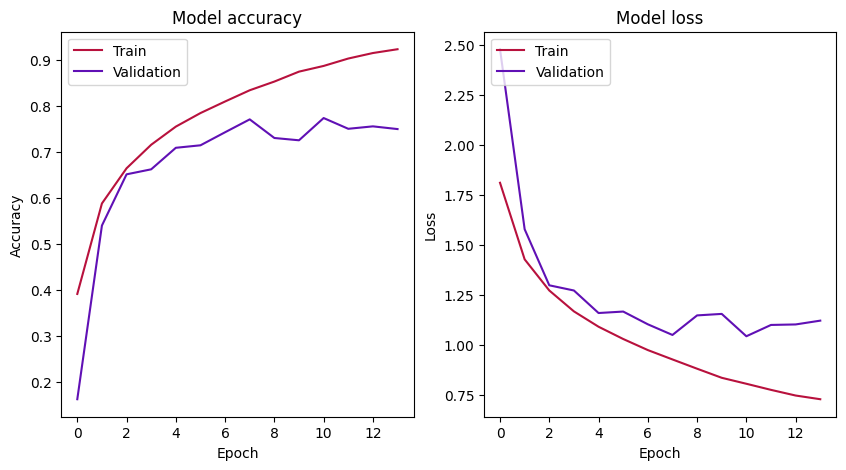

In [13]:
plot_learning_curve(history)

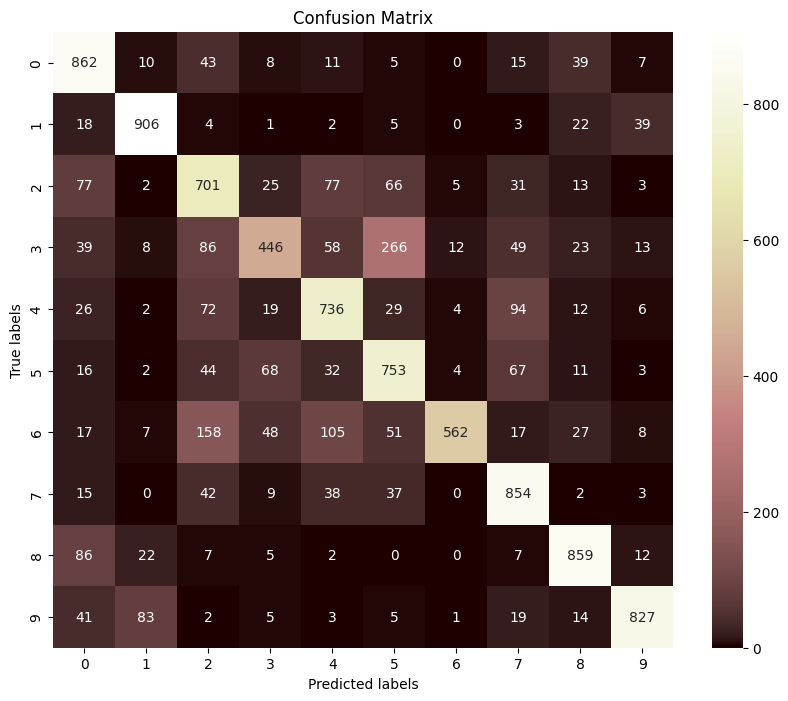

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [14]:
cm = confusion_matrix(y_test_unit8, y_pred_uint8)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

id2class

# Друга модель
Без Early stopping

In [15]:
model_2 = CNN_Classifier(n_classes = len(id2class))
model_2.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-4, weight_decay = 1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.05),
    metrics=['accuracy']
)

In [16]:
model_2.build((None, 32, 32, 3))
model_2.summary()

Model: "cnn__classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_3 (ConvBlock)    multiple                  75904     
                                                                 
 conv_block_4 (ConvBlock)    multiple                  111040    
                                                                 
 conv_block_5 (ConvBlock)    multiple                  111040    
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 head (ClassificationHead)   multiple                  6900266   
                                                                 
Total params: 7198250 (27.46 MB)
Trainable params: 7197866 (27.46 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [17]:
history_2 = model_2.fit(
    x = x_train,
    y = y_train,
    epochs = 40,
    batch_size = 128,
    #Early stopping OFF
    validation_data = (x_test, y_test)
)

Epoch 1/40
391/391 [==============================] - 32s 71ms/step - loss: 1.9858 - accuracy: 0.2920 - val_loss: 2.2393 - val_accuracy: 0.2038
Epoch 2/40
391/391 [==============================] - 28s 73ms/step - loss: 1.4435 - accuracy: 0.5278 - val_loss: 1.2925 - val_accuracy: 0.6036
Epoch 3/40
391/391 [==============================] - 28s 72ms/step - loss: 1.2330 - accuracy: 0.6226 - val_loss: 1.2585 - val_accuracy: 0.6183
Epoch 4/40
391/391 [==============================] - 28s 72ms/step - loss: 1.1095 - accuracy: 0.6784 - val_loss: 1.1449 - val_accuracy: 0.6683
Epoch 5/40
391/391 [==============================] - 27s 70ms/step - loss: 1.0207 - accuracy: 0.7164 - val_loss: 1.1214 - val_accuracy: 0.6767
Epoch 6/40
391/391 [==============================] - 28s 72ms/step - loss: 0.9554 - accuracy: 0.7465 - val_loss: 1.0360 - val_accuracy: 0.7106
Epoch 7/40
391/391 [==============================] - 27s 69ms/step - loss: 0.8877 - accuracy: 0.7741 - val_loss: 1.0056 - val_accuracy:

In [18]:
y_pred = model_2.predict(x_test)
y_pred_uint8 = np.argmax(y_pred, axis=1).astype(np.uint8)
y_test_unit8 = np.argmax(y_test, axis=1).astype(np.uint8)

313/313 [==============================] - 2s 6ms/step


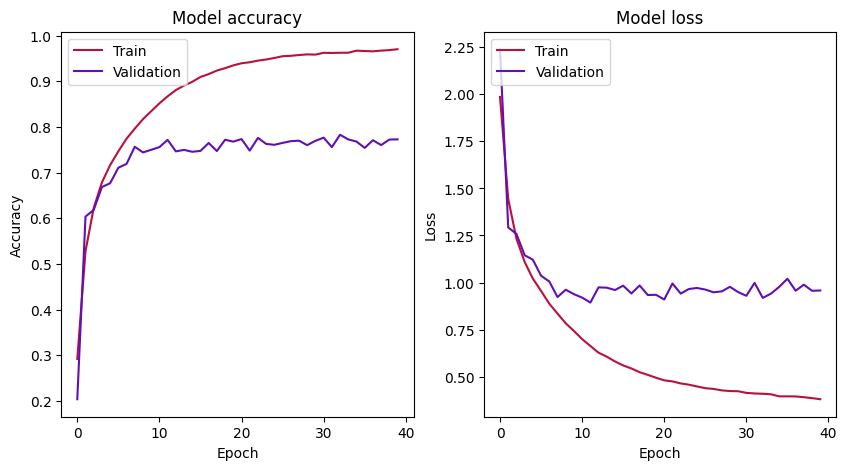

In [19]:
plot_learning_curve(history_2)

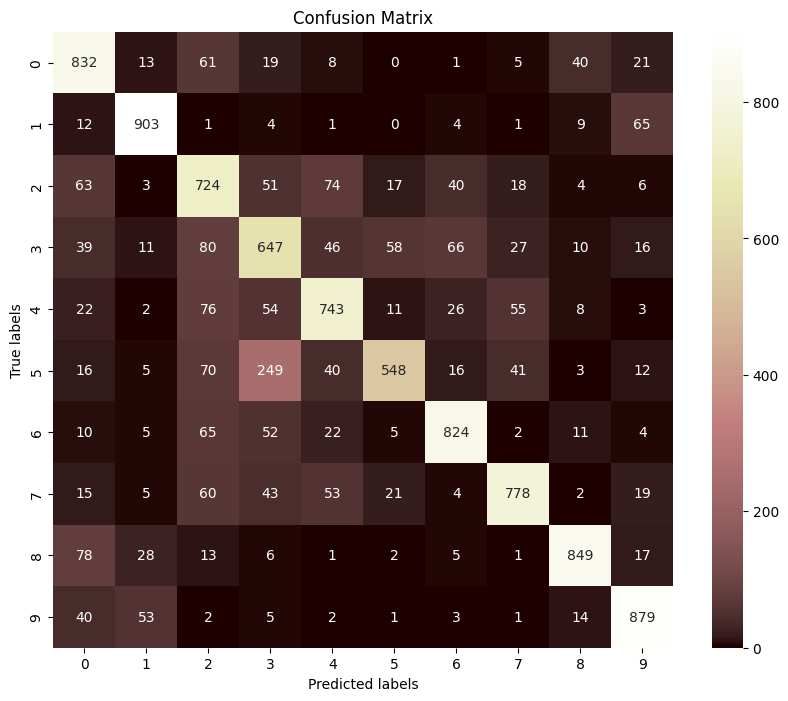

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [20]:
cm = confusion_matrix(y_test_unit8, y_pred_uint8)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='pink', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

id2class

# Порівняння результатів
Виведення графіків першої та другої моделі

In [21]:
def plot_learning_curve_all(history_1, history_2, model_names=['With ES', 'Without ES']):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(history_1.history['accuracy'], color='#b8113d', label=f'{model_names[0]} Train')
    axs[0].plot(history_1.history['val_accuracy'], color='#6010b5', label=f'{model_names[0]} Validation')
    axs[0].plot(history_2.history['accuracy'], color='#ff7f0e', linestyle='--', label=f'{model_names[1]} Train')
    axs[0].plot(history_2.history['val_accuracy'], color='#00aedb', linestyle='--', label=f'{model_names[1]} Validation')
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='lower right')

    axs[1].plot(history_1.history['loss'], color='#b8113d', label=f'{model_names[0]} Train')
    axs[1].plot(history_1.history['val_loss'], color='#6010b5', label=f'{model_names[0]} Validation')
    axs[1].plot(history_2.history['loss'], color='#ff7f0e', linestyle='--', label=f'{model_names[1]} Train')
    axs[1].plot(history_2.history['val_loss'], color='#00aedb', linestyle='--', label=f'{model_names[1]} Validation')
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

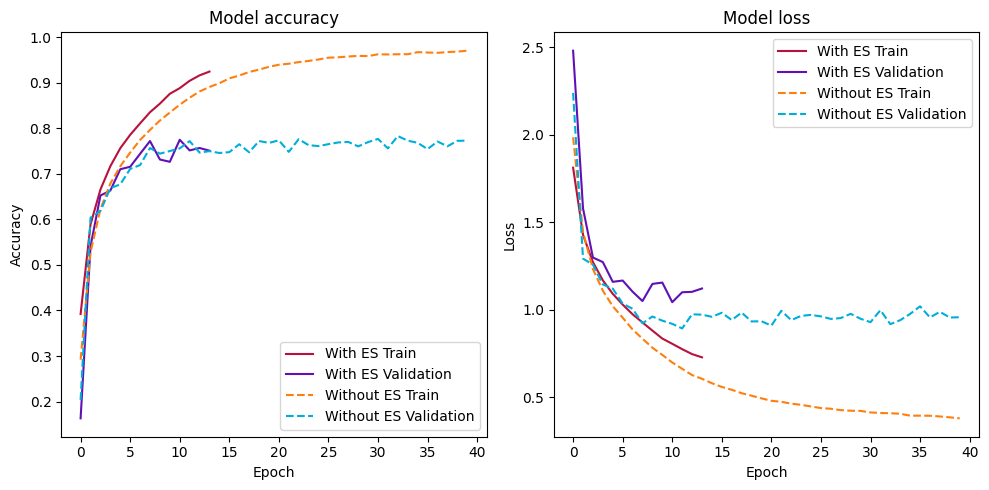

In [22]:
plot_learning_curve_all(history, history_2)

# Висновок
В результаті викоання цієї лабораторної роботи було удосконалено модель, розроблену в попередніх лабораторних роботах. Ця модель продемонструвала значно вищу точність (77% до 72%) за рахунок застосування методів регуляризації.